In [1]:

import torch
import torchaudio
import matplotlib.pyplot as plt
torchaudio.set_audio_backend("sox_io")
path = '/Users/alessandrolicciardi/Desktop/PhD PoliTo/projects/wst_watkins_marinemammals/data/'
import os
y_target = []
samples_per_class = []
data_list = []
sample_rates = []
for (i,class_name) in enumerate(os.listdir(path)):
    y_target.append(class_name)
    sr_tmp = []
    x_tmp = []
    for (j,file_name) in enumerate(os.listdir(path+class_name)):
        mf = torchaudio.info(path+class_name+'/'+file_name)
        if mf.bits_per_sample in [16,24,32]:

            x, sr = torchaudio.load(path+class_name+'/'+file_name)
            x_tmp.append(x)
            sr_tmp.append(sr)
    samples_per_class.append(j+1)
    data_list.append(x_tmp)
    sample_rates.append(sr_tmp)

data_full_list =[x for ls in data_list for x in ls]
srate_full_list =[sr for ls in sample_rates for x in ls]
y_labs = []
for i,nm in enumerate(y_target):
    k = 0
    while (k < len(data_list[i])):
        y_labs.append(nm)
        k += 1
import numpy as np

In [2]:
len(y_target)
# Cetaceans Indices
cetaceans_indices = [
    1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
    21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36
]
# Mysticetes Indices
mysticetes_indices = [
    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36
]

# Odontocetes Indices
odontocetes_indices = [
    1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13
]


# Pinnipeds Indices
pinnipeds_indices = [
    0, 7, 26, 33, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52
]

# Sirenians Indices
sirenians_indices = [53]


In [3]:
dt_tmp = [data_list[i] for i in cetaceans_indices]
data_cet = [x for ls in dt_tmp for x in ls]

In [4]:
dt_tmp = [data_list[i] for i in odontocetes_indices]
data_odo = [x for ls in dt_tmp for x in ls]

In [5]:
dt_tmp = [data_list[i] for i in mysticetes_indices]
data_mys = [x for ls in dt_tmp for x in ls]

In [6]:
dt_tmp = [data_list[i] for i in pinnipeds_indices]
data_pin = [x for ls in dt_tmp for x in ls]

In [7]:
dt_tmp = [data_list[i] for i in sirenians_indices]
dt_sir = [x for ls in dt_tmp for x in ls]

In [8]:
from torch.nn.functional import pad
def cutter(X,cut_point): #cuts and centers
    cut_list = []
    cut_point = int(cut_point)
    j = 0

    for x in X:
        n_len = x.shape[1]
        add_pts = cut_point-n_len

        if (n_len<= cut_point):
            pp_left = int(add_pts/2)
            pp_right = add_pts - pp_left
            cut_list.append(pad(x, (pp_left,pp_right)))

        else :

            center_time = int(n_len/2)
            pp_left = int(cut_point-center_time)
            pp_right = cut_point - pp_left
            cut_list.append(x[:,center_time-pp_left: center_time+ pp_right])
        j += 1

    return torch.cat(cut_list)

In [9]:
cut_point= 4000
X_sir = cutter(dt_sir, cut_point)
X_pin = cutter(data_pin, cut_point)
X_cet = cutter(data_cet, cut_point)
X_odo = cutter(data_odo, cut_point)
X_mys = cutter(data_mys, cut_point)

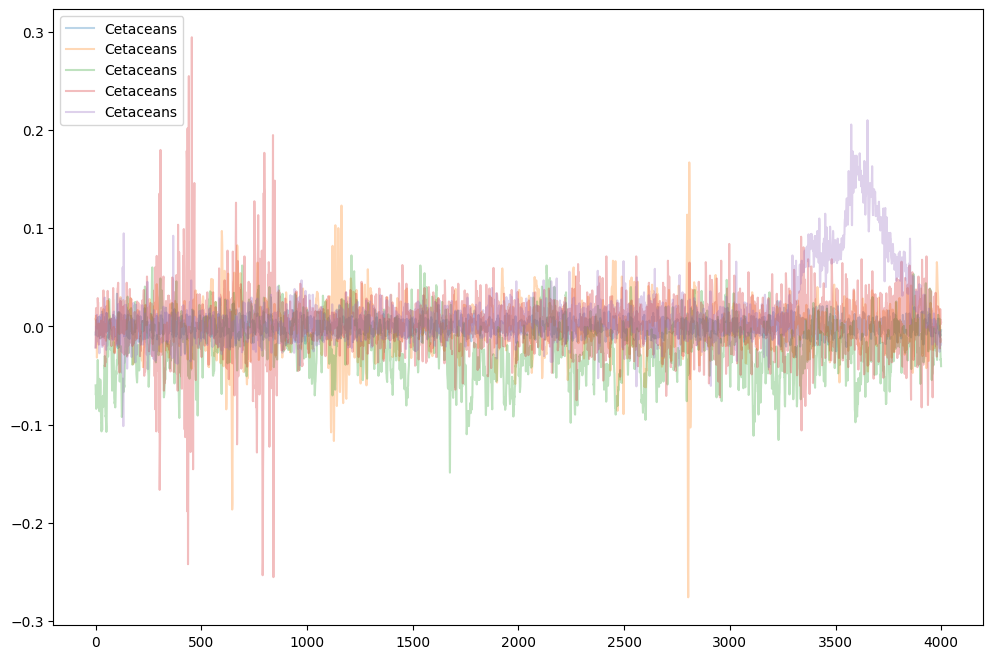

In [10]:
from numpy.random import randint
rand_ind = randint(len(X_cet), size = 5)
fig = plt.figure(figsize=(12,8))
tt = np.arange(X_cet.shape[1])
for j in range(5):

    plt.plot(tt, X_cet[rand_ind[j]], label = 'Cetaceans', alpha = 0.3)
plt.legend()
plt.show()



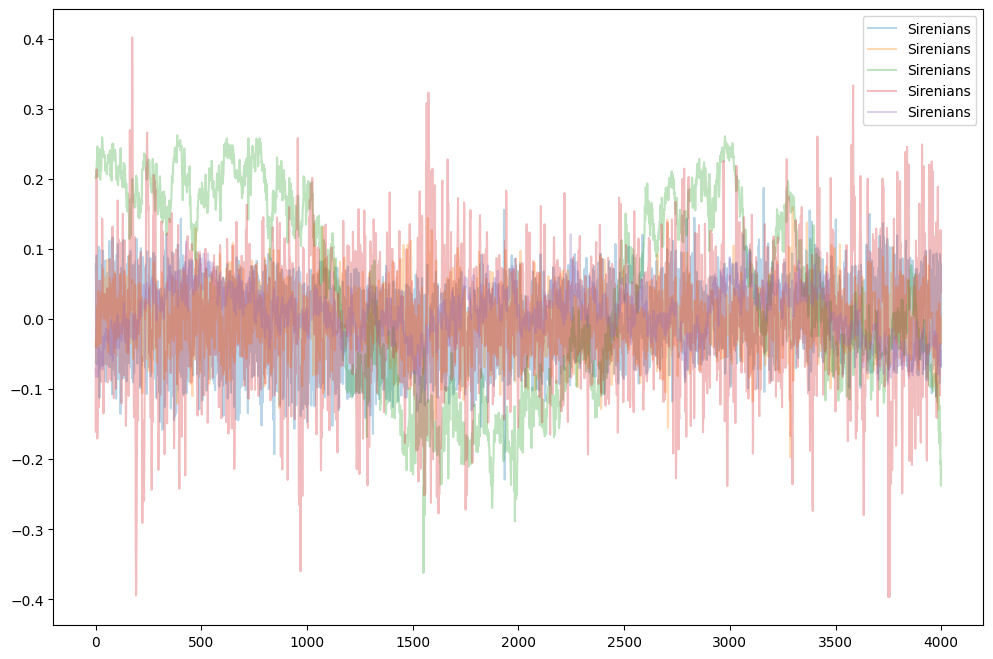

In [11]:
fig = plt.figure(figsize=(12,8))
rand_ind = randint(len(X_sir), size = 5)
tt = np.arange(X_sir.shape[1])
for j in range(5):

    plt.plot(tt, X_sir[rand_ind[j]], label = 'Sirenians', alpha = 0.3)
plt.legend()
plt.show()


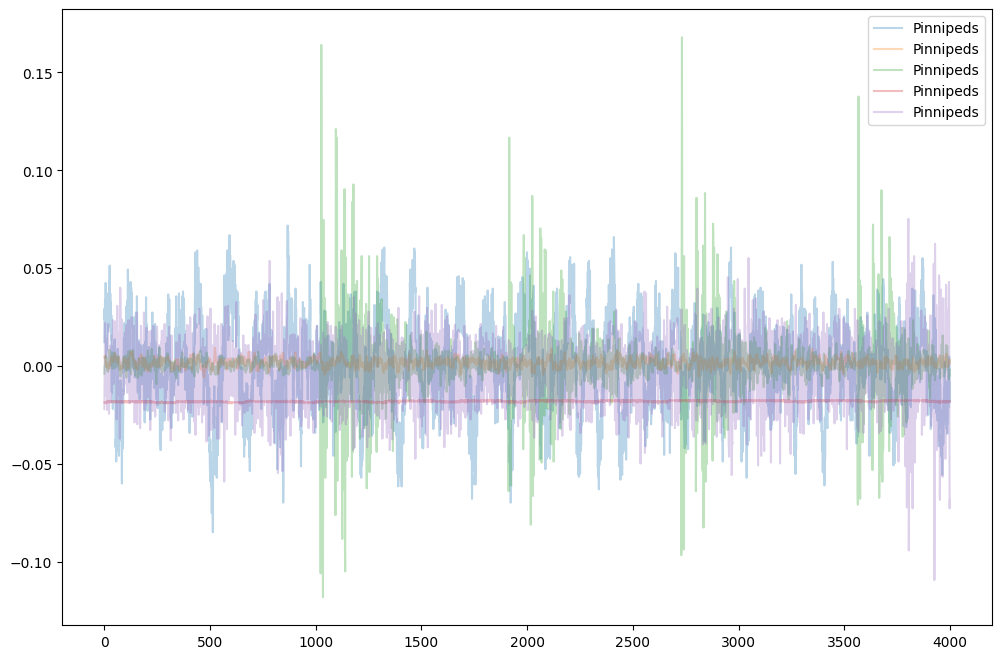

In [12]:
fig = plt.figure(figsize=(12,8))
rand_ind = randint(len(X_pin), size = 5)
tt = np.arange(X_pin.shape[1])
for j in range(5):

    plt.plot(tt, X_pin[rand_ind[j]], label = 'Pinnipeds', alpha = 0.3)
plt.legend()
plt.show()

In [13]:
def standardize(X):
    st = torch.std(X, dim=1, keepdim=True)
    mn = torch.mean(X, dim=1, keepdim=True)
    return (X - mn) / st

X_cet = standardize(X_cet)
X_odo = standardize(X_odo)
X_mys = standardize(X_mys)
X_pin = standardize(X_pin)
X_sir = standardize(X_sir)


In [14]:
from kymatio.torch import Scattering1D

J = 7
Q = 10
T = cut_point
scattering = Scattering1D(J, T, Q)


In [15]:
S_cet = scattering.forward(X_cet)
S_sir = scattering.forward(X_sir)
S_pin = scattering.forward(X_pin)
S_odo = scattering.forward(X_odo)
S_mys = scattering.forward(X_mys)


In [16]:
meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)


def median_norm(X):
    md = torch.median(X)
    sn = torch.std(X)
    return (X - md) / sn


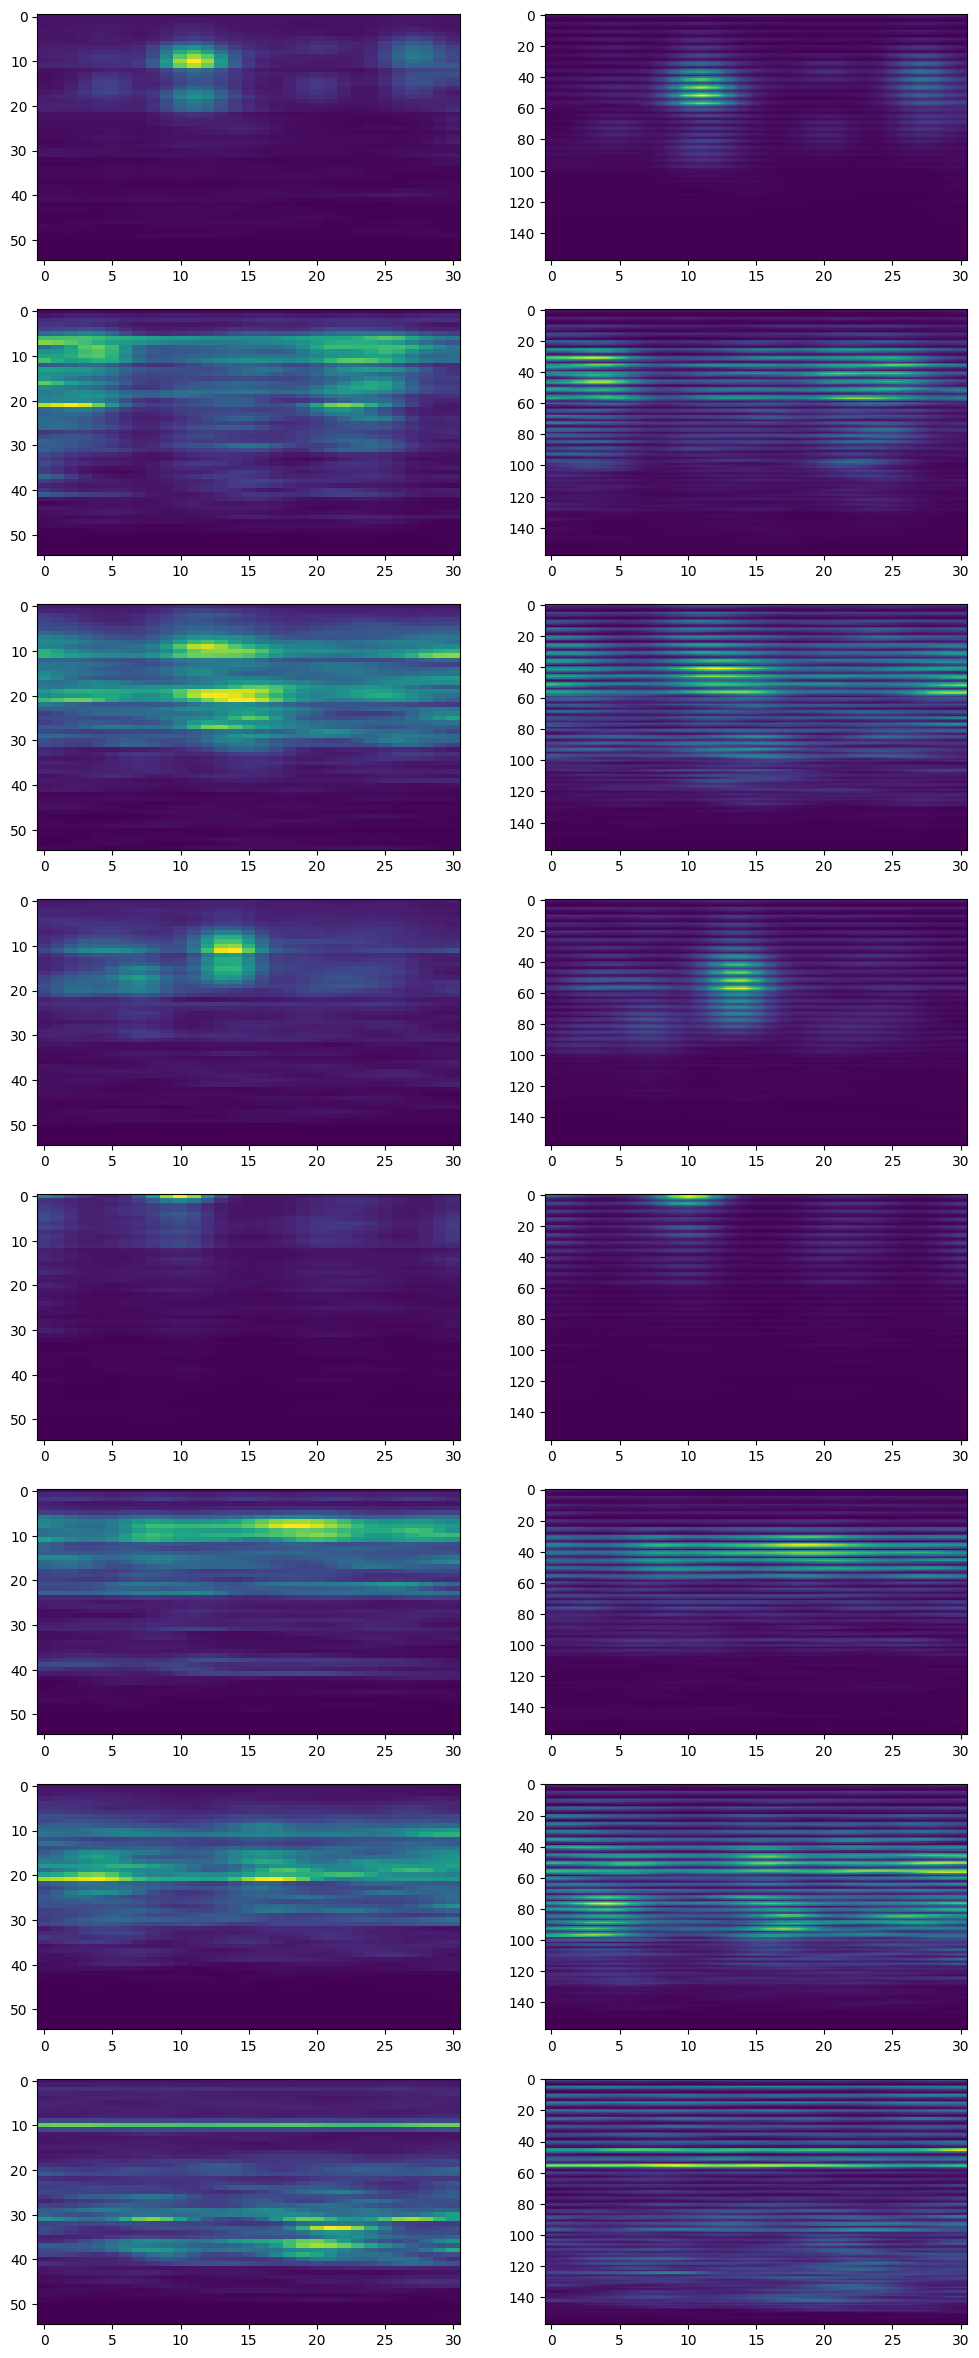

In [17]:
rand_ind = randint(len(X_odo), size = 8)
fig, ax = plt.subplots(8, 2, figsize=(12, 30))

for j in range(8):
    ax[j, 0].imshow(median_norm(S_odo[rand_ind[j]][order1]), aspect='auto', cmap = 'viridis')
    ax[j, 1].imshow(median_norm(S_odo[rand_ind[j]][order2]), aspect='auto', cmap = 'viridis')



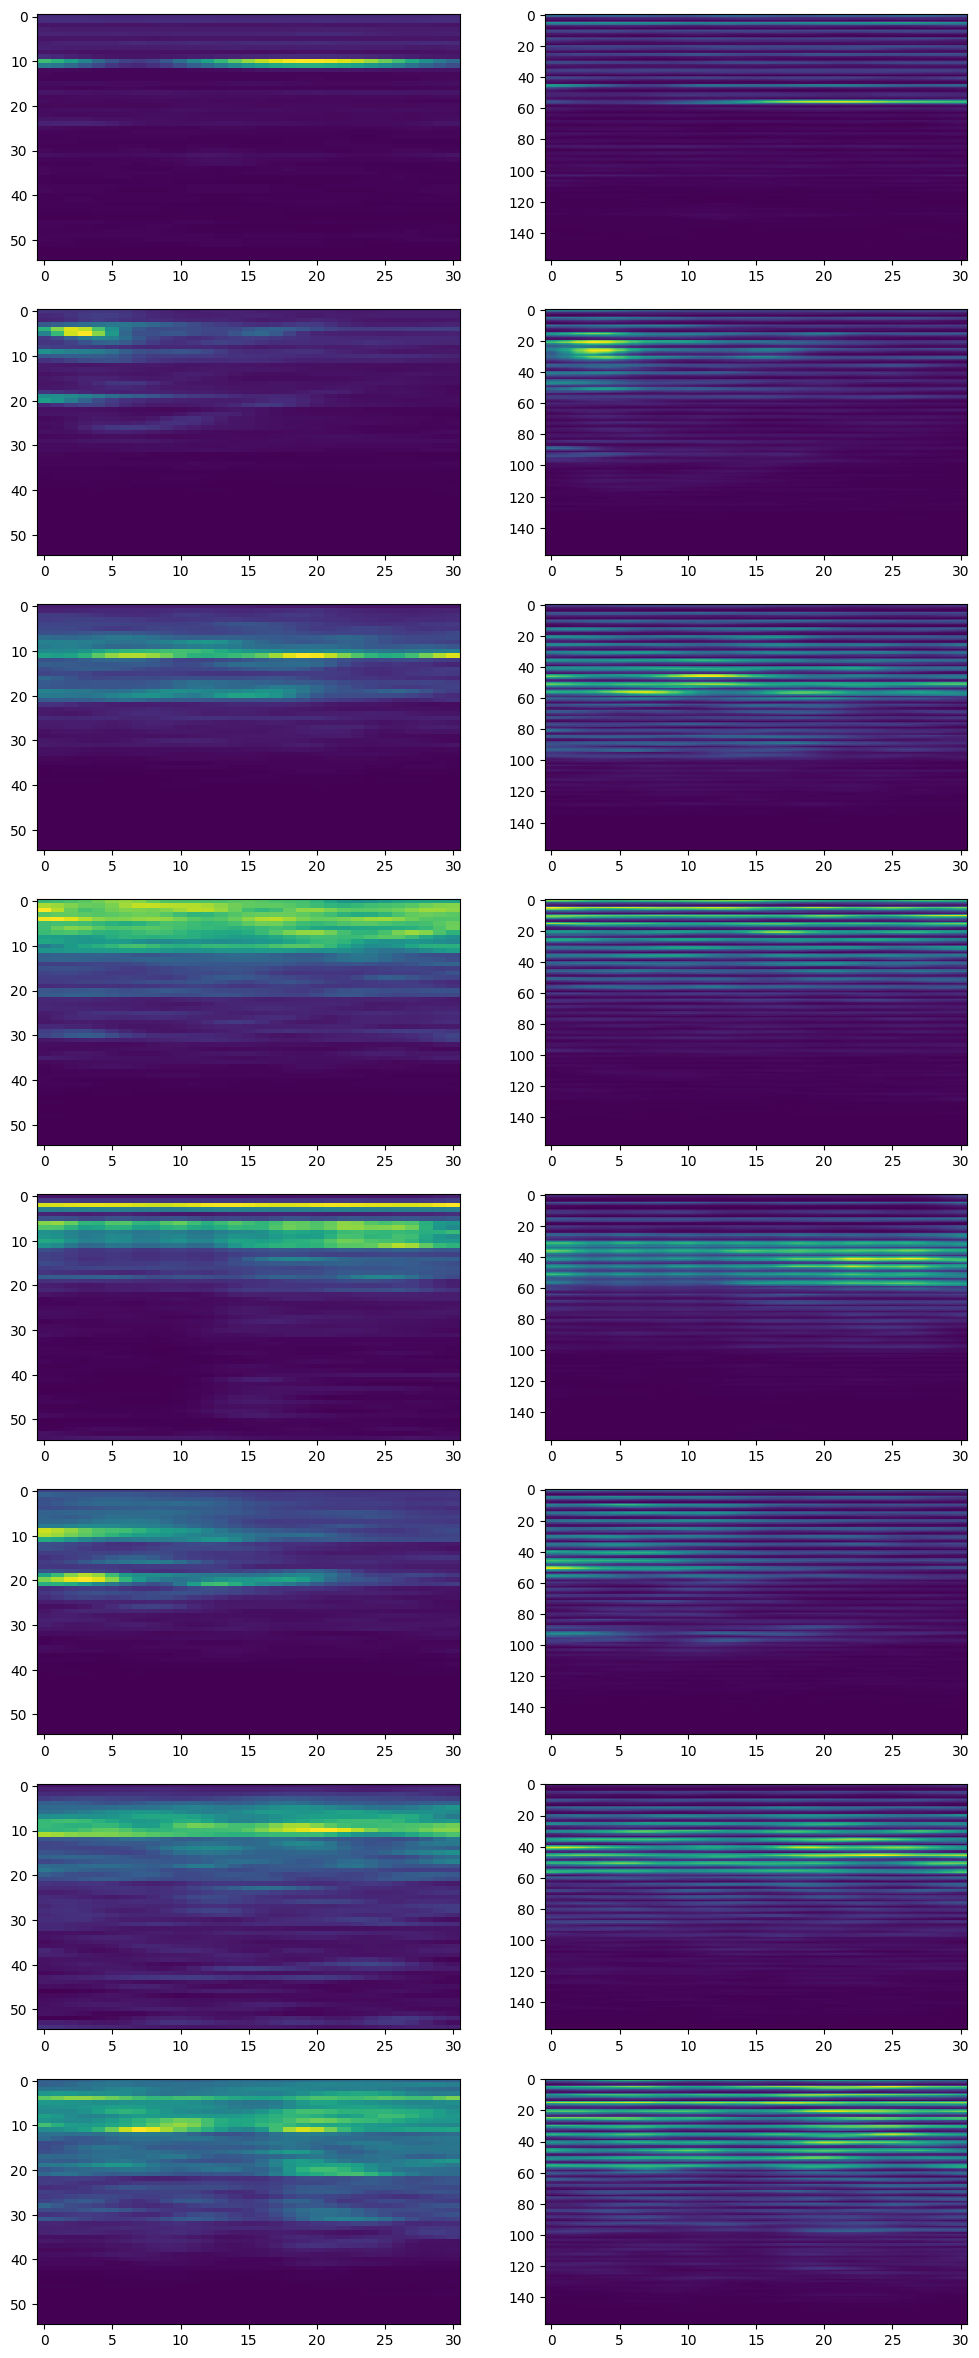

In [18]:
rand_ind = randint(len(X_mys), size = 8)
fig, ax = plt.subplots(8, 2, figsize=(12, 30))

for j in range(8):
    ax[j, 0].imshow(median_norm(S_mys[rand_ind[j]][order1]), aspect='auto', cmap = 'viridis')
    ax[j, 1].imshow(median_norm(S_mys[rand_ind[j]][order2]), aspect='auto', cmap = 'viridis')



In [19]:
X_cut = cutter(data_full_list, cut_point)


In [20]:
X_cut = standardize(X_cut)


In [21]:
S_full = scattering.forward(X_cut)


In [22]:

SX_med = S_full
for i in range(S_full.shape[0]):
    SX_med[i][order0] = median_norm(S_full[i][order0])
    SX_med[i][order1] = median_norm(S_full[i][order1])
    SX_med[i][order2] = median_norm(S_full[i][order2])
# I should reduce the input size of around a tenth (input feature size around 10^3) with CenterCrop
SX_med = SX_med[:, 1:, :]  #remove zeroth order wst
SX_flat = SX_med.reshape(-1, SX_med.shape[1] * SX_med.shape[2]).numpy()


In [23]:
SX_med = S_cet
for i in range(S_cet.shape[0]):
    SX_med[i][order0] = median_norm(S_cet[i][order0])
    SX_med[i][order1] = median_norm(S_cet[i][order1])
    SX_med[i][order2] = median_norm(S_cet[i][order2])
# I should reduce the input size of around a tenth (input feature size around 10^3) with CenterCrop
SX_med = SX_med[:, 1:, :]  #remove zeroth order wst
SX_flat_cet = SX_med.reshape(-1, SX_med.shape[1] * SX_med.shape[2]).numpy()

In [24]:
SX_med = S_odo
for i in range(S_odo.shape[0]):
    SX_med[i][order0] = median_norm(S_odo[i][order0])
    SX_med[i][order1] = median_norm(S_odo[i][order1])
    SX_med[i][order2] = median_norm(S_odo[i][order2])
# I should reduce the input size of around a tenth (input feature size around 10^3) with CenterCrop
SX_med = SX_med[:, 1:, :]  #remove zeroth order wst
SX_flat_odo = SX_med.reshape(-1, SX_med.shape[1] * SX_med.shape[2]).numpy()

In [25]:
SX_med = S_mys
for i in range(S_odo.shape[0]):
    SX_med[i][order0] = median_norm(S_mys[i][order0])
    SX_med[i][order1] = median_norm(S_mys[i][order1])
    SX_med[i][order2] = median_norm(S_mys[i][order2])
# I should reduce the input size of around a tenth (input feature size around 10^3) with CenterCrop
SX_med = SX_med[:, 1:, :]  #remove zeroth order wst
SX_flat_mys = SX_med.reshape(-1, SX_med.shape[1] * SX_med.shape[2]).numpy()

In [26]:
SX_med = S_sir
for i in range(S_sir.shape[0]):
    SX_med[i][order0] = median_norm(S_sir[i][order0])
    SX_med[i][order1] = median_norm(S_sir[i][order1])
    SX_med[i][order2] = median_norm(S_sir[i][order2])
# I should reduce the input size of around a tenth (input feature size around 10^3) with CenterCrop
SX_med = SX_med[:, 1:, :]  #remove zeroth order wst
SX_flat_sir = SX_med.reshape(-1, SX_med.shape[1] * SX_med.shape[2]).numpy()

In [27]:

SX_med = S_pin
for i in range(S_sir.shape[0]):
    SX_med[i][order0] = median_norm(S_pin[i][order0])
    SX_med[i][order1] = median_norm(S_pin[i][order1])
    SX_med[i][order2] = median_norm(S_pin[i][order2])
# I should reduce the input size of around a tenth (input feature size around 10^3) with CenterCrop
SX_med = SX_med[:, 1:, :]  #remove zeroth order wst
SX_flat_pin = SX_med.reshape(-1, SX_med.shape[1] * SX_med.shape[2]).numpy()

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components= .9).fit(SX_flat)


In [29]:
cet_pca = pca.transform(SX_flat_cet)
sir_pca = pca.transform(SX_flat_sir)
pin_pca = pca.transform(SX_flat_pin)
mys_pca = pca.transform(SX_flat_mys)
odo_pca = pca.transform(SX_flat_odo)

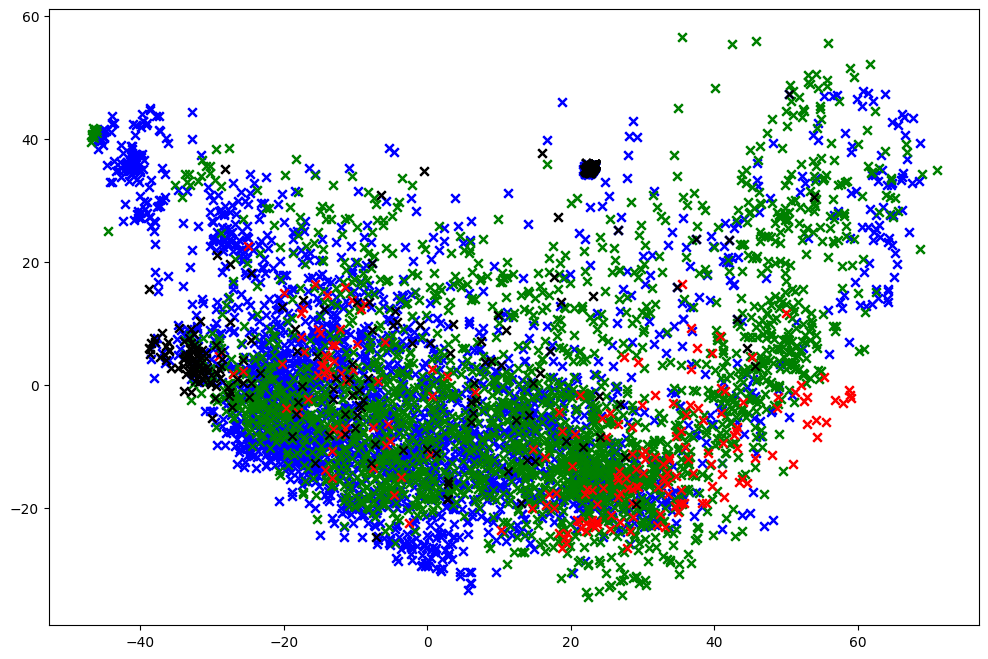

In [30]:
fig = plt.figure(figsize = (12,8))
for j in range(3):
    plt.scatter(mys_pca[:,0],mys_pca[:,1], marker= 'x', c = 'b', label = 'mysticets')
    plt.scatter(odo_pca[:,0],odo_pca[:,1], marker= 'x', c = 'g', label = 'odontocets')
    plt.scatter(sir_pca[:,0],sir_pca[:,1], marker= 'x', c = 'r', label = 'sirenians')
    plt.scatter(pin_pca[:,0],pin_pca[:,1], marker= 'x', c = 'k', label = 'pinnipeds' )


plt.show()

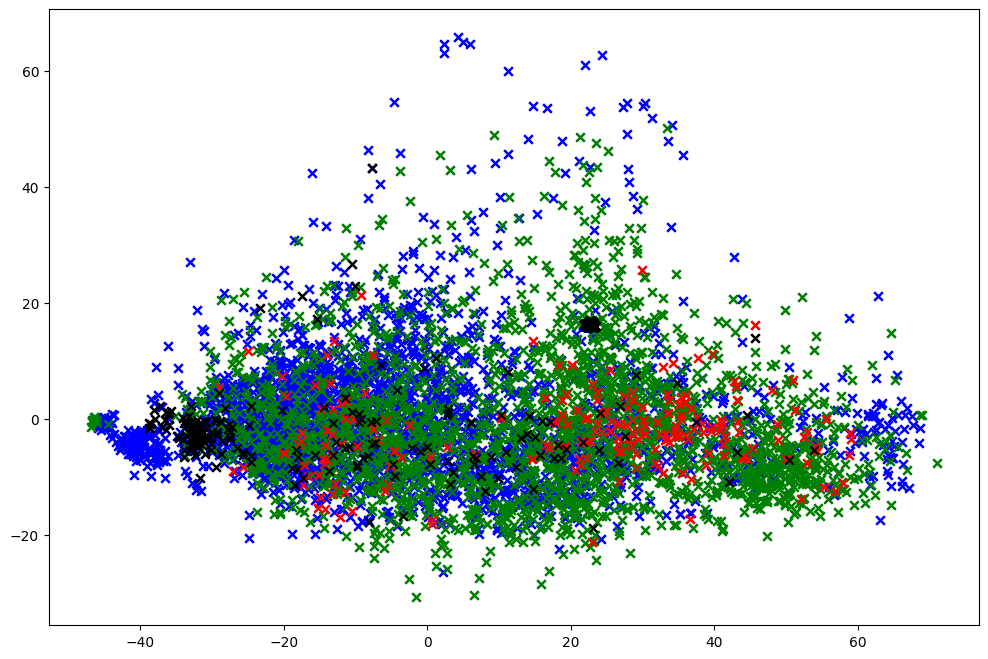

In [31]:
fig = plt.figure(figsize = (12,8))
for j in range(3):
    plt.scatter(mys_pca[:,0],mys_pca[:,2], marker= 'x', c = 'b', label = 'mysticets')
    plt.scatter(odo_pca[:,0],odo_pca[:,2], marker= 'x', c = 'g', label = 'odontocets')
    plt.scatter(sir_pca[:,0],sir_pca[:,2], marker= 'x', c = 'r', label = 'sirenians')
    plt.scatter(pin_pca[:,0],pin_pca[:,2], marker= 'x', c = 'k', label = 'pinnipeds' )



plt.show()


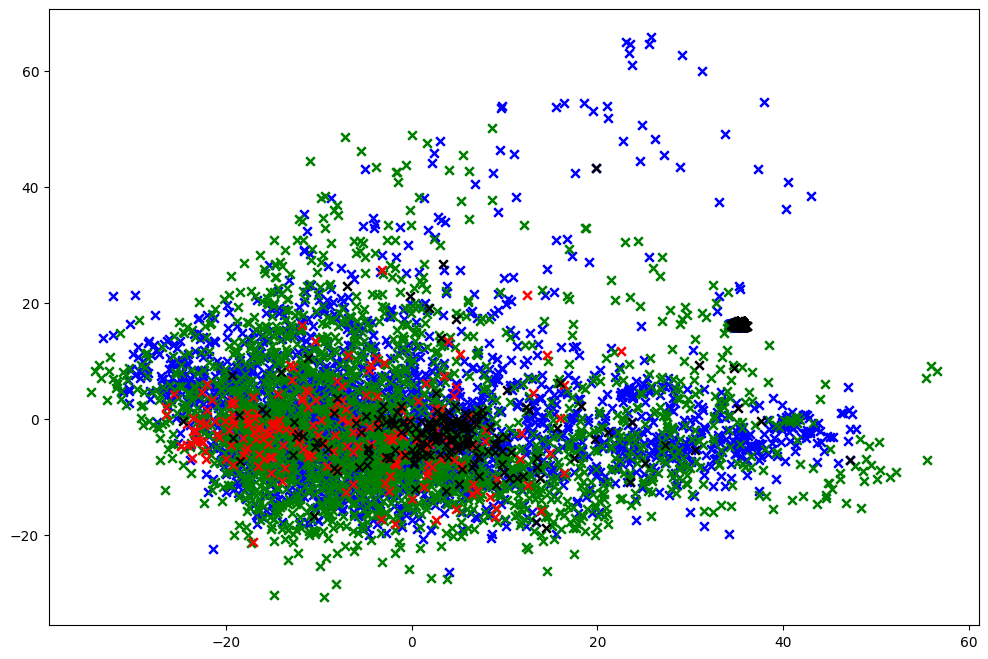

In [32]:
fig = plt.figure(figsize = (12,8))
for j in range(3):
    plt.scatter(mys_pca[:,1],mys_pca[:,2], marker= 'x', c = 'b', label = 'mysticets')
    plt.scatter(odo_pca[:,1],odo_pca[:,2], marker= 'x', c = 'g', label = 'odontocets')
    plt.scatter(sir_pca[:,1],sir_pca[:,2], marker= 'x', c = 'r', label = 'sirenians')
    plt.scatter(pin_pca[:,1],pin_pca[:,2], marker= 'x', c = 'k', label = 'pinnipeds' )


plt.show()


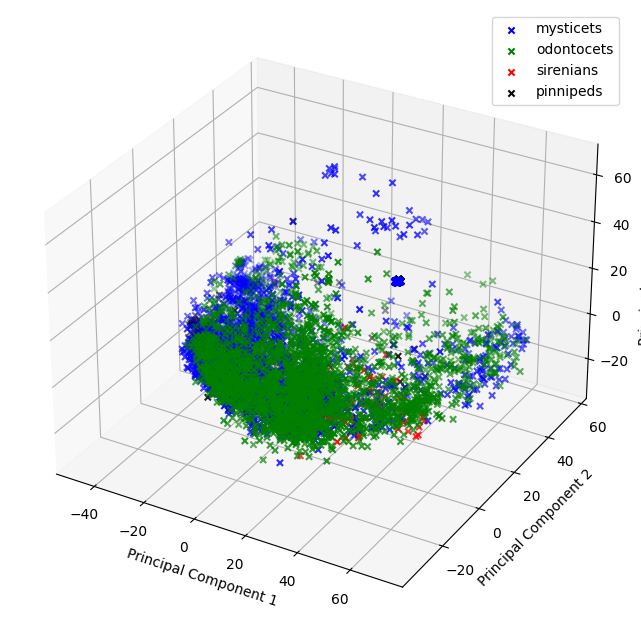

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming mys_pca, odo_pca, sir_pca, and pin_pca are 2D arrays with three principal components each

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plots for each category
ax.scatter(mys_pca[:, 0], mys_pca[:, 1], mys_pca[:, 2], marker='x', c='b', label='mysticets')
ax.scatter(odo_pca[:, 0], odo_pca[:, 1], odo_pca[:, 2], marker='x', c='g', label='odontocets')
ax.scatter(sir_pca[:, 0], sir_pca[:, 1], sir_pca[:, 2], marker='x', c='r', label='sirenians')
ax.scatter(pin_pca[:, 0], pin_pca[:, 1], pin_pca[:, 2], marker='x', c='k', label='pinnipeds')

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set legend
ax.legend()

plt.show()


In [54]:
mean_odo = SX_flat_odo.mean(axis = 0).reshape(1,-1)
mean_mys = SX_flat_mys.mean(axis = 0).reshape(1,-1)
mean_pin = SX_flat_pin.mean(axis = 0).reshape(1,-1)
mean_sir = SX_flat_sir.mean(axis = 0).reshape(1,-1)

In [56]:
pca_mean_odo = pca.transform(mean_odo)
pca_mean_mys = pca.transform(mean_mys)
pca_mean_sir = pca.transform(mean_sir)
pca_mean_pin = pca.transform(mean_pin)

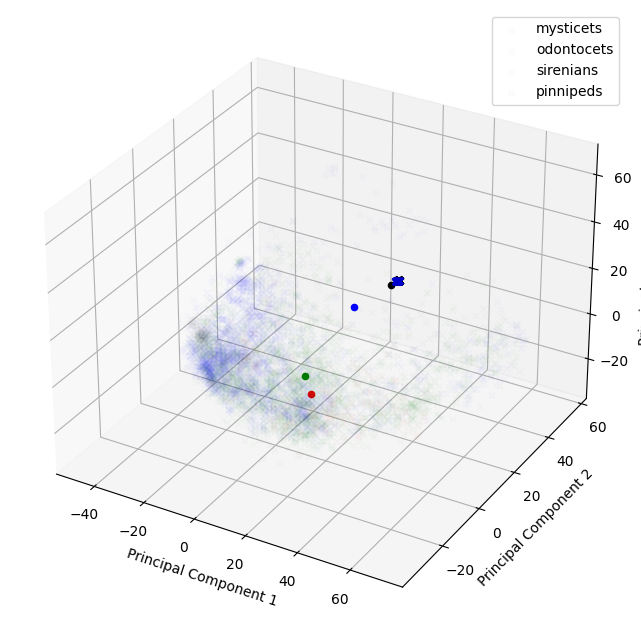

In [59]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plots for each category
ax.scatter(mys_pca[:, 0], mys_pca[:, 1], mys_pca[:, 2], marker='x', c='b', label='mysticets', alpha = .02)
ax.scatter(odo_pca[:, 0], odo_pca[:, 1], odo_pca[:, 2], marker='x', c='g', label='odontocets', alpha = .02)
ax.scatter(sir_pca[:, 0], sir_pca[:, 1], sir_pca[:, 2], marker='x', c='r', label='sirenians', alpha = .02)
ax.scatter(pin_pca[:, 0], pin_pca[:, 1], pin_pca[:, 2], marker='x', c='k', label='pinnipeds', alpha = .02)
ax.scatter(pca_mean_mys[:, 0], pca_mean_mys[:, 1], pca_mean_mys[:, 2], c = 'b', marker = 'o')
ax.scatter(pca_mean_odo[:, 0], pca_mean_odo[:, 1], pca_mean_odo[:, 2], c = 'g', marker = 'o')
ax.scatter(pca_mean_sir[:, 0], pca_mean_sir[:, 1], pca_mean_sir[:, 2], c = 'r', marker = 'o')
ax.scatter(pca_mean_pin[:, 0], pca_mean_pin[:, 1], pca_mean_pin[:, 2], c = 'k', marker = 'o')

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set legend
ax.legend()

plt.show()

In [68]:
from sklearn.metrics.pairwise import euclidean_distances as L2
wst_odo_distl2 = [L2(s.reshape(1,-1), mean_odo) for s in SX_flat_odo]
wst_mys_distl2 = [L2(s.reshape(1,-1), mean_mys) for s in SX_flat_mys]
wst_sir_distl2 = [L2(s.reshape(1,-1), mean_sir) for s in SX_flat_sir]
wst_pin_distl2 = [L2(s.reshape(1,-1), mean_pin) for s in SX_flat_pin]

In [69]:
def CV(x):

    return np.std(x)/ np.abs(np.mean(x))


In [70]:
print(f'CV with Euclidean and WST odontocetes: {CV(wst_odo_distl2)}')
print(f'CV with Euclidean and WST mysticetes: {CV(wst_mys_distl2)}')
print(f'CV with Euclidean and WST sirenians: {CV(wst_sir_distl2)}')
print(f'CV with Euclidean and WST pinnipeds: {CV(wst_pin_distl2)}')

CV with Euclidean and WST odontocetes: 0.235861673951149
CV with Euclidean and WST mysticetes: 0.5687969923019409
CV with Euclidean and WST sirenians: 0.2384721338748932
CV with Euclidean and WST pinnipeds: 2.1224923133850098


In [71]:
from sklearn.metrics import mean_squared_error as MSE
wst_odo_distmse = [MSE(s.reshape(1,-1), mean_odo) for s in SX_flat_odo]
wst_mys_distmse = [MSE(s.reshape(1,-1), mean_mys) for s in SX_flat_mys]
wst_sir_distmse = [MSE(s.reshape(1,-1), mean_sir) for s in SX_flat_sir]
wst_pin_distmse = [MSE(s.reshape(1,-1), mean_pin) for s in SX_flat_pin]


In [73]:
print(f'CV with MSE and WST odontocetes: {CV(wst_odo_distmse)}')
print(f'CV with MSE and WST mysticetes: {CV(wst_mys_distmse)}')
print(f'CV with MSE and WST sirenians: {CV(wst_sir_distmse)}')
print(f'CV with MSE and WST pinnipeds: {CV(wst_pin_distmse)}')


CV with MSE and WST odontocetes: 0.48584234714508057
CV with MSE and WST mysticetes: 1.0400463342666626
CV with MSE and WST sirenians: 0.4583146870136261
CV with MSE and WST pinnipeds: 3.971407413482666


In [79]:
from torchaudio.transforms import MelSpectrogram

spectr = MelSpectrogram(normalized= True, n_mels = 64)

M_cet = spectr(X_cet)
M_sir = spectr(X_sir)
M_pin = spectr(X_pin)
M_odo = spectr(X_odo)
M_mys = spectr(X_mys)
M_full = spectr(X_cut)

In [86]:
M_mys_flat = M_mys.reshape(-1,M_mys.shape[1]*M_mys.shape[2]).numpy()
M_odo_flat = M_odo.reshape(-1,M_mys.shape[1]*M_mys.shape[2]).numpy()
M_sir_flat = M_sir.reshape(-1,M_mys.shape[1]*M_mys.shape[2]).numpy()
M_pin_flat = M_pin.reshape(-1,M_mys.shape[1]*M_mys.shape[2]).numpy()
M_flat = M_full.reshape(-1, M_mys.shape[1]*M_mys.shape[2]).numpy()

In [88]:

pca = PCA(n_components=.9).fit(M_flat)


sir_pca = pca.transform(M_sir_flat)
pin_pca = pca.transform(M_pin_flat)
mys_pca = pca.transform(M_mys_flat)
odo_pca = pca.transform(M_odo_flat)

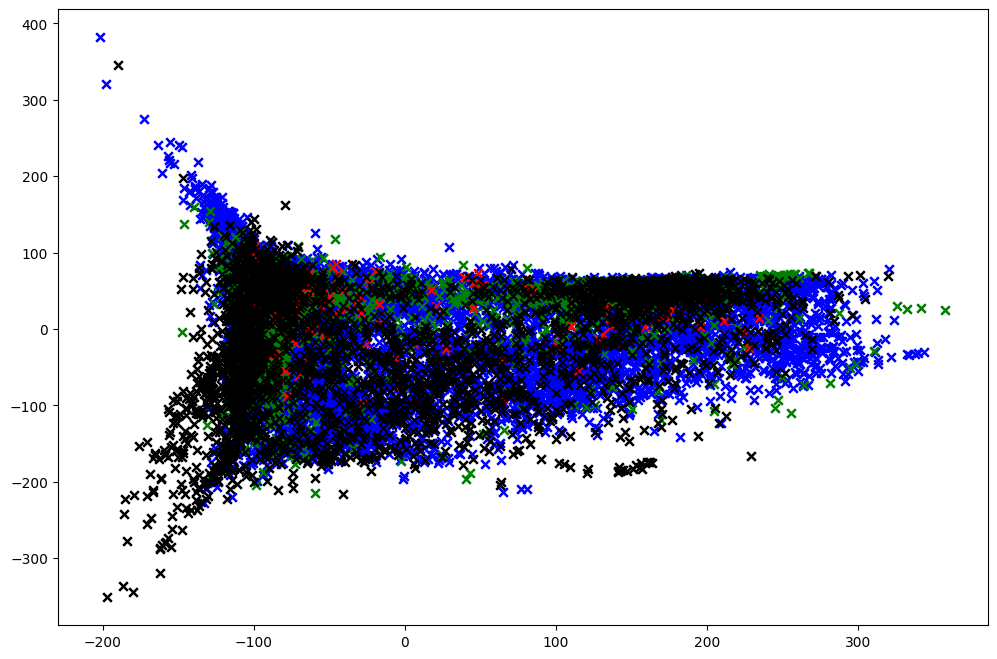

In [89]:
fig = plt.figure(figsize = (12,8))
for j in range(3):
    plt.scatter(mys_pca[:,0],mys_pca[:,1], marker= 'x', c = 'b', label = 'mysticets')
    plt.scatter(odo_pca[:,0],odo_pca[:,1], marker= 'x', c = 'g', label = 'odontocets')
    plt.scatter(sir_pca[:,0],sir_pca[:,1], marker= 'x', c = 'r', label = 'sirenians')
    plt.scatter(pin_pca[:,0],pin_pca[:,1], marker= 'x', c = 'k', label = 'pinnipeds' )


plt.show()


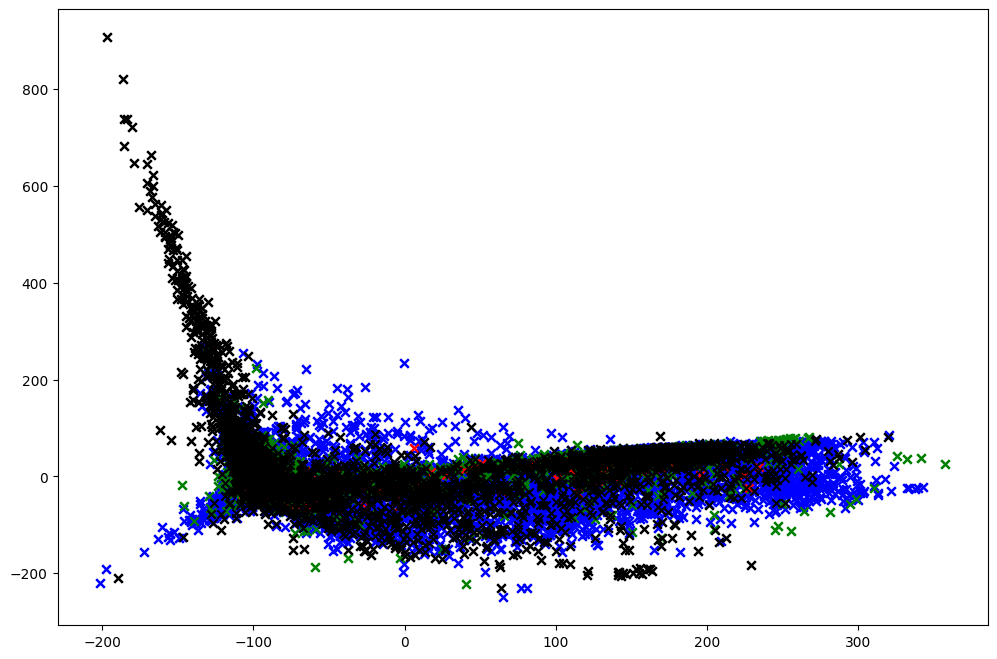

In [90]:
fig = plt.figure(figsize = (12,8))
for j in range(3):
    plt.scatter(mys_pca[:,0],mys_pca[:,2], marker= 'x', c = 'b', label = 'mysticets')
    plt.scatter(odo_pca[:,0],odo_pca[:,2], marker= 'x', c = 'g', label = 'odontocets')
    plt.scatter(sir_pca[:,0],sir_pca[:,2], marker= 'x', c = 'r', label = 'sirenians')
    plt.scatter(pin_pca[:,0],pin_pca[:,2], marker= 'x', c = 'k', label = 'pinnipeds' )



plt.show()


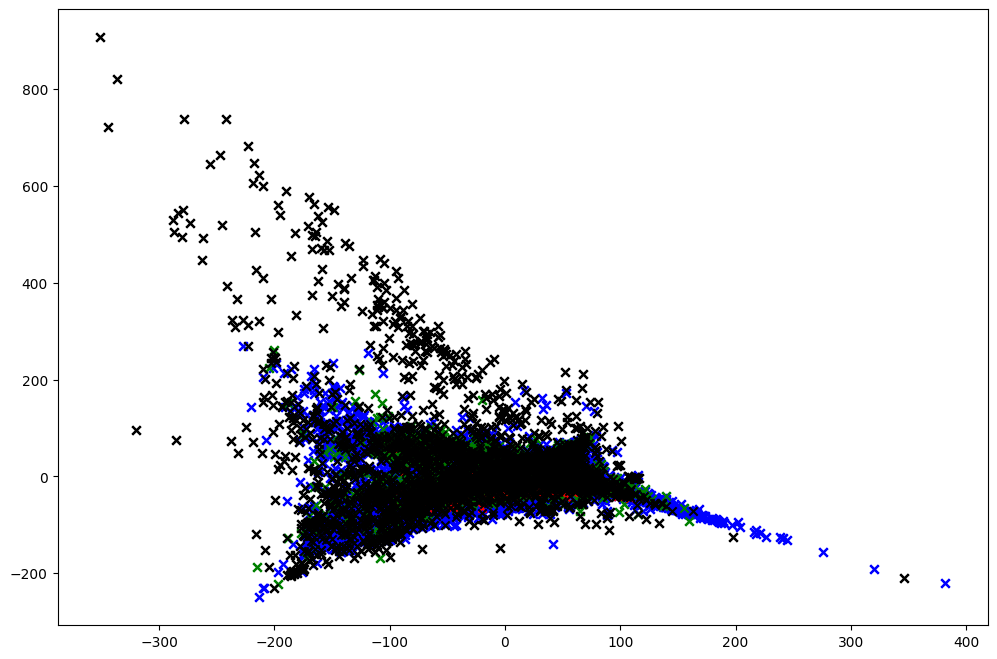

In [91]:
fig = plt.figure(figsize = (12,8))
for j in range(3):
    plt.scatter(mys_pca[:,1],mys_pca[:,2], marker= 'x', c = 'b', label = 'mysticets')
    plt.scatter(odo_pca[:,1],odo_pca[:,2], marker= 'x', c = 'g', label = 'odontocets')
    plt.scatter(sir_pca[:,1],sir_pca[:,2], marker= 'x', c = 'r', label = 'sirenians')
    plt.scatter(pin_pca[:,1],pin_pca[:,2], marker= 'x', c = 'k', label = 'pinnipeds' )


plt.show()


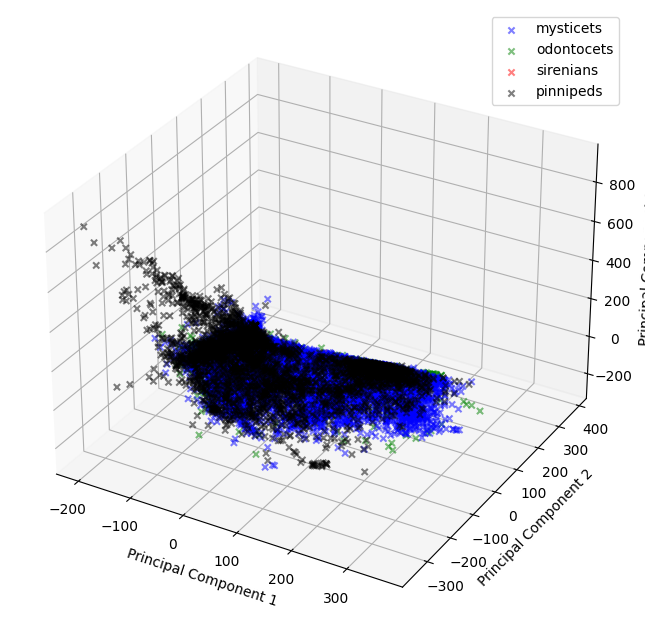

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming mys_pca, odo_pca, sir_pca, and pin_pca are 2D arrays with three principal components each

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plots for each category
ax.scatter(mys_pca[:, 0], mys_pca[:, 1], mys_pca[:, 2], marker='x', c='b', label='mysticets', alpha = .5)
ax.scatter(odo_pca[:, 0], odo_pca[:, 1], odo_pca[:, 2], marker='x', c='g', label='odontocets', alpha = .5)
ax.scatter(sir_pca[:, 0], sir_pca[:, 1], sir_pca[:, 2], marker='x', c='r', label='sirenians', alpha = .5)
ax.scatter(pin_pca[:, 0], pin_pca[:, 1], pin_pca[:, 2], marker='x', c='k', label='pinnipeds', alpha = .5)

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set legend
ax.legend()

plt.show()


In [92]:
mean_odo = M_odo_flat.mean(axis=0).reshape(1, -1)
mean_mys = M_mys_flat.mean(axis=0).reshape(1, -1)
mean_pin = M_pin_flat.mean(axis=0).reshape(1, -1)
mean_sir = M_sir_flat.mean(axis=0).reshape(1, -1)
pca_mean_odo = pca.transform(mean_odo)
pca_mean_mys = pca.transform(mean_mys)
pca_mean_sir = pca.transform(mean_sir)
pca_mean_pin = pca.transform(mean_pin)


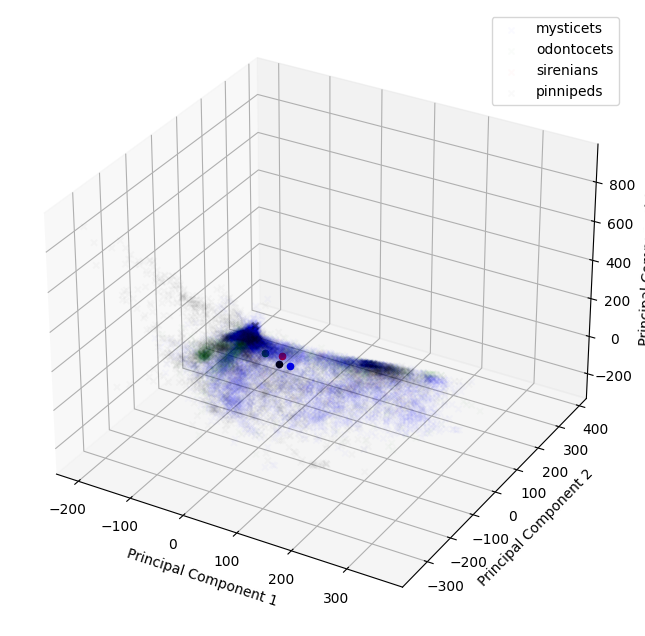

In [96]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plots for each category
ax.scatter(mys_pca[:, 0], mys_pca[:, 1], mys_pca[:, 2], marker='x', c='b', label='mysticets', alpha = .02)
ax.scatter(odo_pca[:, 0], odo_pca[:, 1], odo_pca[:, 2], marker='x', c='g', label='odontocets', alpha = .02)
ax.scatter(sir_pca[:, 0], sir_pca[:, 1], sir_pca[:, 2], marker='x', c='r', label='sirenians', alpha = .02)
ax.scatter(pin_pca[:, 0], pin_pca[:, 1], pin_pca[:, 2], marker='x', c='k', label='pinnipeds', alpha = .02)
ax.scatter(pca_mean_mys[:, 0], pca_mean_mys[:, 1], pca_mean_mys[:, 2], c = 'b', marker = 'o')
ax.scatter(pca_mean_odo[:, 0], pca_mean_odo[:, 1], pca_mean_odo[:, 2], c = 'g', marker = 'o')
ax.scatter(pca_mean_sir[:, 0], pca_mean_sir[:, 1], pca_mean_sir[:, 2], c = 'r', marker = 'o')
ax.scatter(pca_mean_pin[:, 0], pca_mean_pin[:, 1], pca_mean_pin[:, 2], c = 'k', marker = 'o')

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set legend
ax.legend()

plt.show()


In [97]:
mel_odo_distl2 = [L2(s.reshape(1,-1), mean_odo) for s in M_odo_flat]
mel_mys_distl2 = [L2(s.reshape(1,-1), mean_mys) for s in M_mys_flat]
mel_sir_distl2 = [L2(s.reshape(1,-1), mean_sir) for s in M_sir_flat]
mel_pin_distl2 = [L2(s.reshape(1,-1), mean_pin) for s in M_pin_flat]


In [98]:
print(f'CV with MSE and Mel odontocetes: {CV(mel_odo_distl2)}')
print(f'CV with MSE and Mel mysticetes: {CV(mel_mys_distl2)}')
print(f'CV with MSE and Mel sirenians: {CV(mel_sir_distl2)}')
print(f'CV with MSE and Mel pinnipeds: {CV(mel_pin_distl2)}')


CV with MSE and Mel odontocetes: 0.5661910772323608
CV with MSE and Mel mysticetes: 0.5418378710746765
CV with MSE and Mel sirenians: 0.44113612174987793
CV with MSE and Mel pinnipeds: 0.634783148765564


In [99]:
mel_odo_distmse = [MSE(s.reshape(1, -1), mean_odo) for s in M_odo_flat]
mel_mys_distmse = [MSE(s.reshape(1, -1), mean_mys) for s in M_mys_flat]
mel_sir_distmse = [MSE(s.reshape(1, -1), mean_sir) for s in M_sir_flat]
mel_pin_distmse = [MSE(s.reshape(1, -1), mean_pin) for s in M_pin_flat]

print(f'CV with MSE and Mel odontocetes: {CV(mel_odo_distmse)}')
print(f'CV with MSE and Mel mysticetes: {CV(mel_mys_distmse)}')
print(f'CV with MSE and Mel sirenians: {CV(mel_sir_distmse)}')
print(f'CV with MSE and Mel pinnipeds: {CV(mel_pin_distmse)}')


CV with MSE and Mel odontocetes: 1.747579574584961
CV with MSE and Mel mysticetes: 1.6392507553100586
CV with MSE and Mel sirenians: 0.914454460144043
CV with MSE and Mel pinnipeds: 1.6710771322250366
